# Imports and Data Generation

In [1]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [2]:
X = np.vstack((
    np.array([1, 1, 1]) + np.random.rand(10, 3),
    np.array([1, 1, -1]) + np.random.rand(10, 3),
    np.array([1, -1, 1]) + np.random.rand(10, 3),
    np.array([1, -1, -1]) + np.random.rand(10, 3),
    np.array([-1, 1, 1]) + np.random.rand(10, 3),
    np.array([-1, 1, -1]) + np.random.rand(10, 3),
    np.array([-1, -1, 1]) + np.random.rand(10, 3),
    np.array([-1, -1, -1]) + np.random.rand(10, 3),
))
y_ally = np.vstack((np.ones((40, 1)), np.zeros((40, 1))))
y_advr_y = np.vstack((np.ones((20, 1)), np.zeros((20, 1)), np.ones((20, 1)), np.zeros((20, 1))))
y_advr_z = np.vstack((np.ones((10, 1)), np.zeros((10, 1)), np.ones((10, 1)), np.zeros((10, 1)), 
                     np.ones((10, 1)), np.zeros((10, 1)), np.ones((10, 1)), np.zeros((10, 1))))

X.shape, y_ally.shape, y_advr_y.shape, y_advr_z.shape

((80, 3), (80, 1), (80, 1), (80, 1))

# Utility

In [66]:
def class_plot(X_input, aspect=True, title=False, orig=True, save=False):
    pca_2 = PCA(n_components=2)
    X_pca_2 = pca_2.fit_transform(X_input)
    pca_3 = PCA(n_components=3)
    X_pca_3 = pca_3.fit_transform(X_input)
#     colors = ['r', 'r', 'g', 'g', 'b', 'b', 'c', 'c']
    colors = ['r', 'b']
    markers = ['o', 'x', '*', 's', 'o', 'x', '*', 's']
    
    if orig:
        fig = plt.figure(figsize=(15,5))
        ax3 = fig.add_subplot(131, projection='3d')
        ax1 = fig.add_subplot(132, projection='3d')
        ax2 = fig.add_subplot(133, projection='3d')
        t3, t1, t2 = '(a)', '(b)', '(c)'
    else:
        fig = plt.figure(figsize=(10,5))
        ax1 = fig.add_subplot(121, projection='3d')
        ax2 = fig.add_subplot(122, projection='3d')
        t1, t2 = '(a)', '(b)'
    if orig:
        m = 0
        for i in range(2):
            for j in range(2):
                for k in range(2):
                    tmp = X_input[np.intersect1d(np.intersect1d(
                        np.where(y_ally == i)[0], 
                        np.where(y_advr_y == j)[0]),
                        np.where(y_advr_z == k)[0]
                    )]
                    ax3.scatter(tmp[:, 0], tmp[:, 1], tmp[:, 2], c=colors[i], marker=markers[m])
                    m += 1
        ax3.set_title(t3, y=-0.2)
        
    m = 0
    for i in range(2):
        for j in range(2):
            for k in range(2):
                tmp = X[np.intersect1d(np.intersect1d(
                    np.where(y_ally == i)[0], 
                    np.where(y_advr_y == j)[0]),
                    np.where(y_advr_z == k)[0]
                )]
                ax1.scatter(tmp[:, 0], tmp[:, 1], tmp[:, 2], c=colors[i], marker=markers[m])
                m += 1
    ax1.set_title("{}".format(t1), y=-0.2)
    print(sum(pca_3.explained_variance_ratio_))
    
    m = 0
    for i in range(2):
        for j in range(2):
            for k in range(2):
                tmp = X_pca_3[np.intersect1d(np.intersect1d(
                    np.where(y_ally == i)[0], 
                    np.where(y_advr_y == j)[0]),
                    np.where(y_advr_z == k)[0]
                )]
                ax2.scatter(tmp[:, 0], tmp[:, 1], c=colors[i], marker=markers[m])
                m += 1
    ax2.set_title("{}".format(t2), y=-0.2)
    print(sum(pca_2.explained_variance_ratio_))

    if save:
        plt.savefig(save, dpi=300)
    else:
        plt.show()

1.0
0.6913843761565862


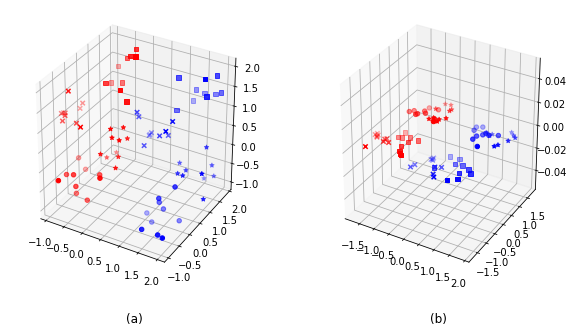

In [67]:
class_plot(X, orig=False)

### Idea

Basically we are trying to learn represenations of any given data in another transformed axes where classification becomes easier along one label but becomes tougher along another one.

- Here we want to differentiate between the two circles while not being able to tell between the two semicircles

In [34]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X)

### Validation after scaling

1.0
0.6905603091714199


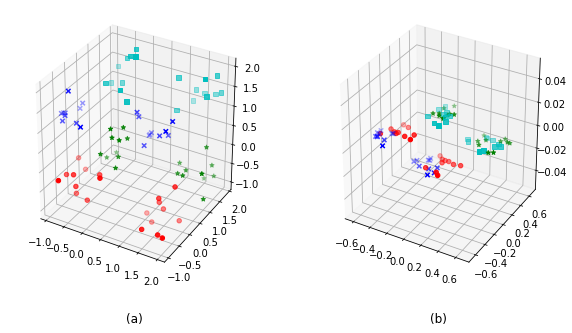

In [27]:
class_plot(X_normalized, title="Original Dataset", orig=False)

# Privacy GAN

In [11]:
import torch

In [12]:
X_torch = torch.Tensor(X_normalized)
y_ally_torch = torch.Tensor(y_ally.reshape(-1, 1))
y_advr_y_torch = torch.Tensor(y_advr_y.reshape(-1, 1))
y_advr_z_torch = torch.Tensor(y_advr_z.reshape(-1, 1))

In [18]:
class Encoder(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Encoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.fc1 = torch.nn.Linear(self.input_size, self.hidden_size)
        self.relu = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(self.hidden_size, self.output_size)
        self.sigmoid = torch.nn.Sigmoid()
        self.tanh = torch.nn.Tanh()
        self.batchnorm = torch.nn.BatchNorm1d(self.hidden_size)
    def forward(self, x):
        hidden = self.fc1(x)
        hidden = self.batchnorm(hidden)
        relu = self.relu(hidden)
        output = self.fc2(relu)
        output = self.tanh(output)
        return output


class Ally(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Ally, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.fc1 = torch.nn.Linear(self.input_size, self.hidden_size)
        self.relu = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(self.hidden_size, self.output_size)
        self.sigmoid = torch.nn.Sigmoid()
        self.tanh = torch.nn.Tanh()
        self.batchnorm = torch.nn.BatchNorm1d(self.hidden_size)
    def forward(self, x):
        hidden = self.fc1(x)
        hidden = self.batchnorm(hidden)
        relu = self.relu(hidden)
        output = self.fc2(relu)
        output = self.sigmoid(output)
        return output


class Adversary(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Adversary, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.fc1 = torch.nn.Linear(self.input_size, self.hidden_size)
        self.relu = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(self.hidden_size, self.output_size)
        self.sigmoid = torch.nn.Sigmoid()
        self.tanh = torch.nn.Tanh()
        self.batchnorm = torch.nn.BatchNorm1d(self.hidden_size)
    def forward(self, x):
        hidden = self.fc1(x)
        hidden = self.batchnorm(hidden)
        relu = self.relu(hidden)
        output = self.fc2(relu)
        output = self.sigmoid(output)
        return output

In [70]:
def train_privacy_gan(alpha, lr_encd, lr_ally, lr_advr, n_iter_gan, d_reps, plot=True, debug=True):
    encoding_dimension = 3
    encoder = Encoder(
        input_size=X_torch.shape[1], 
        hidden_size=encoding_dimension*8, 
        output_size=encoding_dimension*4)
    ally = Ally(
        input_size=encoding_dimension*4, 
        hidden_size=encoding_dimension*8, 
        output_size=y_ally_torch.shape[1])
    adversary_y = Adversary(
        input_size=encoding_dimension*4, 
        hidden_size=encoding_dimension*8, 
        output_size=y_advr_y_torch.shape[1])
    adversary_z = Adversary(
        input_size=encoding_dimension*4, 
        hidden_size=encoding_dimension*8, 
        output_size=y_advr_z_torch.shape[1])

    
    
    criterion = torch.nn.BCEWithLogitsLoss()
    kldiv = torch.nn.KLDivLoss()
    l1_loss = torch.nn.L1Loss()
    optimizer = torch.optim.Adam
    encd_optimizer = optimizer(encoder.parameters(), lr = lr_encd)
    ally_optimizer = optimizer(ally.parameters(), lr=lr_ally)
    advr_y_optimizer = optimizer(adversary_y.parameters(), lr=lr_advr)
    advr_z_optimizer = optimizer(adversary_z.parameters(), lr=lr_advr)
    
    if debug:
        print("epoch \t encoder_train \t ally_train \t advr_y_train \t advr_z_train")

    g_epoch = []
    enc_train = []
    ally_train = []
    advr_y_train = []
    advr_z_train = []
    
    encoder.train()
    ally.train()
    adversary_y.train()
    adversary_z.train()

    for epoch in range(n_iter_gan):
        # set for training
        # Forward passv
        X_ganencoded = encoder(X_torch)
        y_ally_torch_hat = ally(X_ganencoded)
        y_advr_y_torch_hat = adversary_y(X_ganencoded)
        y_advr_z_torch_hat = adversary_z(X_ganencoded)
        # Compute Loss
        ally_loss = criterion(y_ally_torch_hat, y_ally_torch)
        advr_y_loss = -criterion(y_advr_y_torch_hat, y_advr_y_torch)
        advr_z_loss = -criterion(y_advr_z_torch_hat, y_advr_z_torch)
        encd_loss = ally_loss + advr_y_loss + advr_z_loss
        
        encd_optimizer.zero_grad()
        encd_loss.backward()
        encd_optimizer.step()

        for i in range(d_reps):
            X_ganencoded = encoder(X_torch)
            y_ally_torch_hat = ally(X_ganencoded)
            ally_optimizer.zero_grad()
            ally_loss = criterion(y_ally_torch_hat, y_ally_torch)
            ally_loss.backward()
            ally_optimizer.step()
            
            X_ganencoded = encoder(X_torch)
            y_advr_y_torch_hat = adversary_y(X_ganencoded)
            advr_y_optimizer.zero_grad()
            advr_y_loss = criterion(y_advr_y_torch_hat, y_advr_y_torch)
            advr_y_loss.backward()
            advr_y_optimizer.step()
            
            X_ganencoded = encoder(X_torch)
            y_advr_z_torch_hat = adversary_z(X_ganencoded)
            advr_z_optimizer.zero_grad()
            advr_z_loss = criterion(y_advr_z_torch_hat, y_advr_z_torch)
            advr_z_loss.backward()
            advr_z_optimizer.step()

        if plot:
            g_epoch.append(epoch)
            enc_train.append(encd_loss.item())
            ally_train.append(ally_loss.item())
            advr_y_train.append(advr_y_loss.item())
            advr_z_train.append(advr_z_loss.item())
            
        if epoch%500!=0 and (debug or plot):
            continue

        if debug:
            print('{} \t {:.8f} \t {:.8f} \t {:.8f} \t {:.8f}'.format(
                epoch, 
                encd_loss.item(),
                ally_loss.item(),
                advr_y_loss.item(),
                advr_z_loss.item(),
            ))
        
        X_ganencoded = encoder(X_torch)
        class_plot(X_ganencoded.detach().numpy(), False, orig=False)

    if plot:
        plt.plot(g_epoch, enc_train, 'r')
        plt.plot(g_epoch, ally_train, 'b')
        plt.plot(g_epoch, advr_y_train, 'g')
        plt.plot(g_epoch, advr_z_train, 'g.')
        plt.legend([
            'encoder train loss', 
            'ally train loss',
            'advr y train loss',
            'advr z train loss'
        ])
        
        plt.xlabel('number of iterations')
        plt.ylabel('loss')
        plt.show() 

        return encoder  

- maximize the divergence
- no dimensionality reduction here

epoch 	 encoder_train 	 ally_train 	 advr_y_train 	 advr_z_train
0 	 -0.74420768 	 0.70483434 	 0.79964244 	 0.78724670
0.9384927600622177
0.7069903016090393


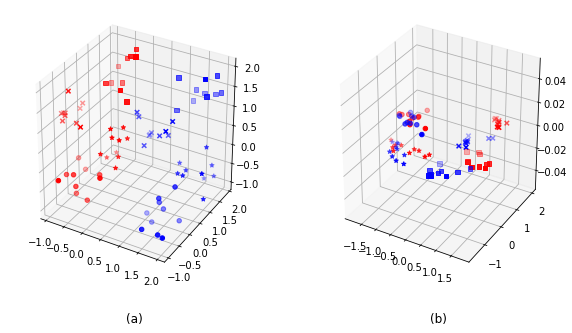

500 	 -0.88310784 	 0.50323337 	 0.69317025 	 0.69317096
1.0
1.0


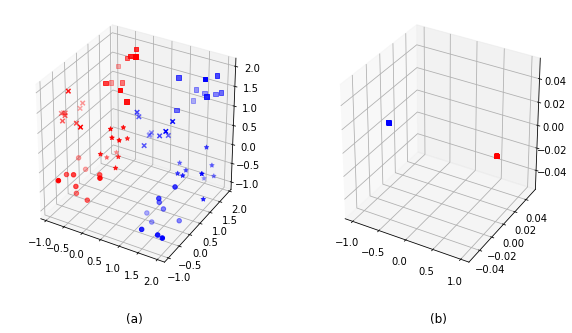

1000 	 -0.88309443 	 0.50321370 	 0.69315392 	 0.69315422
1.0
1.0


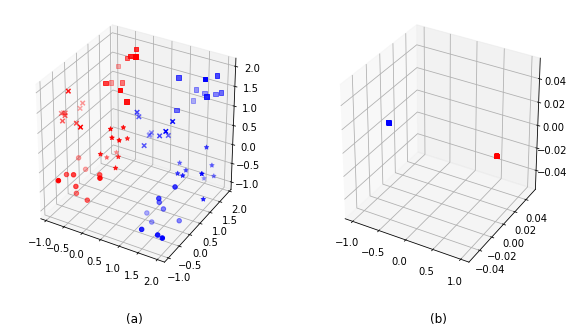

1500 	 -0.88309205 	 0.50320911 	 0.69315064 	 0.69315052
1.0
1.0


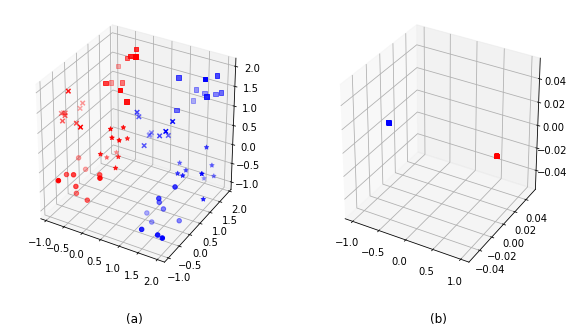

2000 	 -0.88309139 	 0.50320685 	 0.69314921 	 0.69314903
1.0
1.0


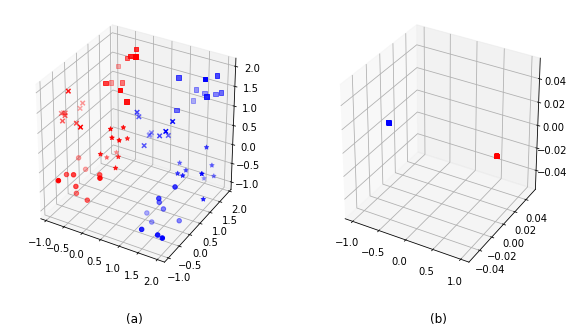

2500 	 -0.88309079 	 0.50320613 	 0.69314843 	 0.69314849
1.0
1.0


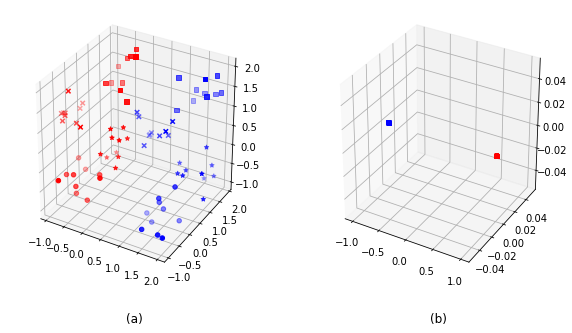

3000 	 -0.88309038 	 0.50320560 	 0.69314814 	 0.69314778
1.0
1.0


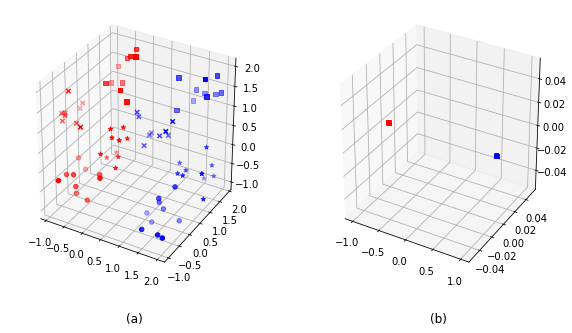

3500 	 -0.88309067 	 0.50320506 	 0.69314778 	 0.69314796
1.0000000000675349
1.0000000000657252


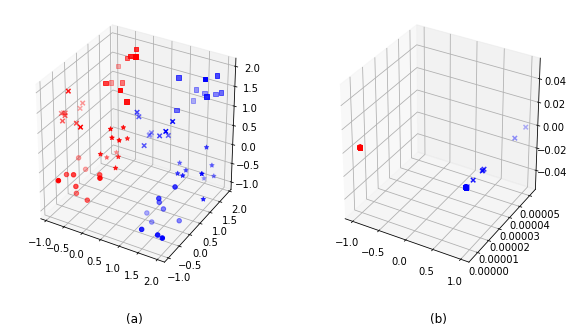

4000 	 -0.88309014 	 0.50320470 	 0.69314718 	 0.69314766
1.000000000036175
1.0000000000345035


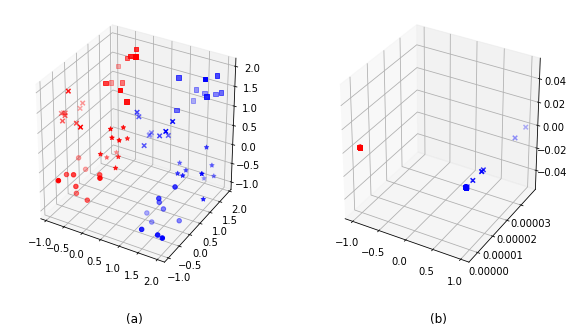

4500 	 -0.88309008 	 0.50320464 	 0.69314718 	 0.69314754
1.0000000000233835
1.0000000000218483


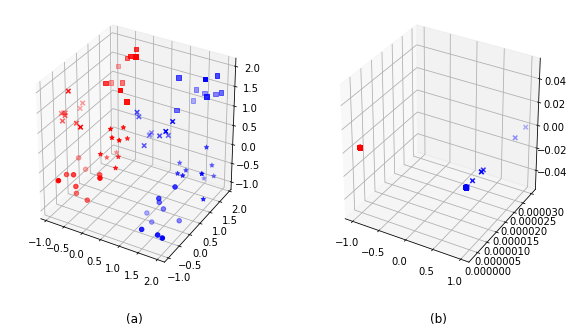

5000 	 -0.88309008 	 0.50320446 	 0.69314700 	 0.69314754
1.000000000016402
1.0000000000149831


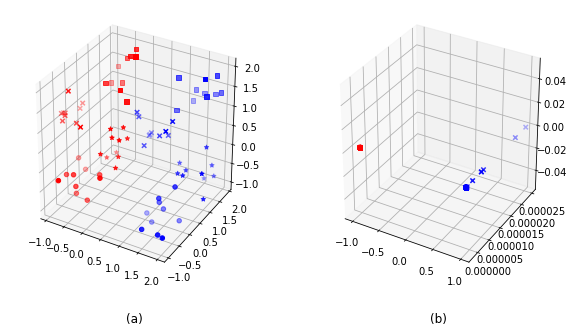

5500 	 -0.88309008 	 0.50320446 	 0.69314706 	 0.69314748
1.00000000001205
1.0000000000107616


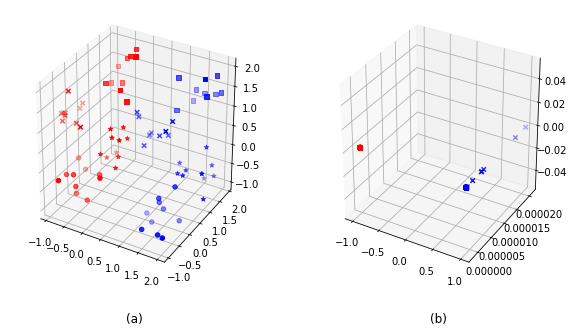

6000 	 -0.88309050 	 0.50320441 	 0.69314748 	 0.69314742
1.0000000000091258
1.0000000000079592


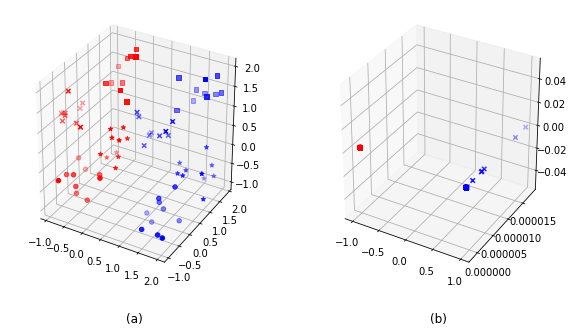

6500 	 -0.88309014 	 0.50320441 	 0.69314718 	 0.69314736
1.0000000000070939
1.00000000000604


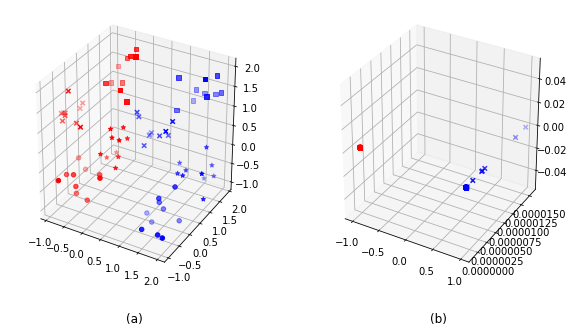

7000 	 -0.88308990 	 0.50320429 	 0.69314688 	 0.69314730
1.0000000000055655
1.000000000004633


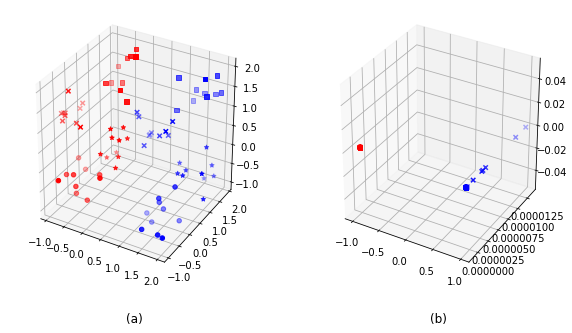

7500 	 -0.88309002 	 0.50320429 	 0.69314700 	 0.69314730
1.000000000004447
1.0000000000036224


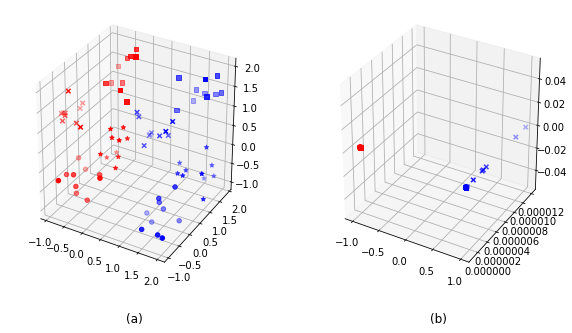

8000 	 -0.88309056 	 0.50320429 	 0.69314754 	 0.69314730
1.0000000000036209
1.0000000000028912


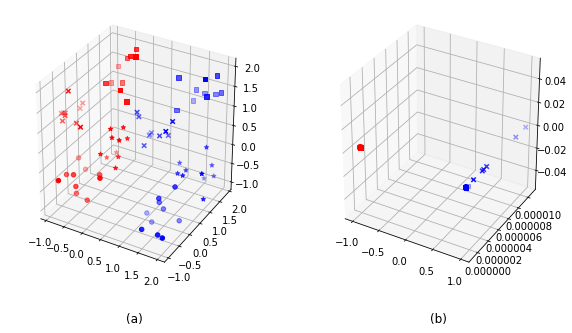

8500 	 -0.88309014 	 0.50320429 	 0.69314712 	 0.69314730
1.000000000002955
1.0000000000023184


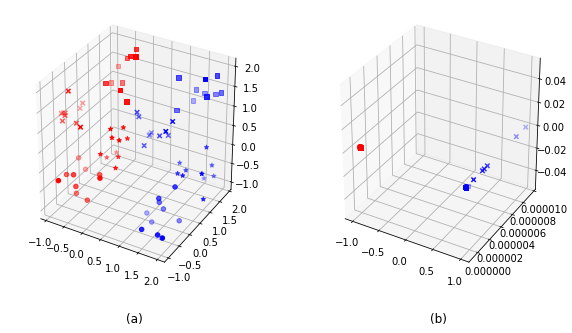

9000 	 -0.88309008 	 0.50320429 	 0.69314742 	 0.69314694
1.000000000002446
1.0000000000018943


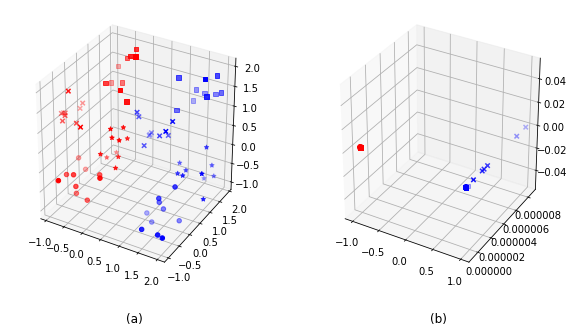

9500 	 -0.88308948 	 0.50320429 	 0.69314688 	 0.69314688
1.0000000000020337
1.0000000000015694


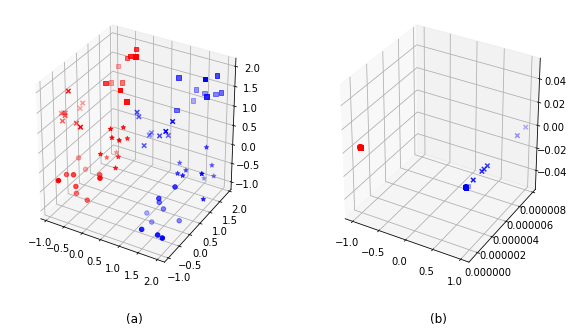

10000 	 -0.88309008 	 0.50320423 	 0.69314742 	 0.69314688
1.0000000000017237
1.0000000000013183


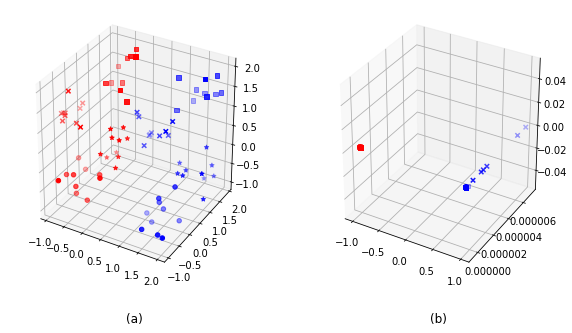

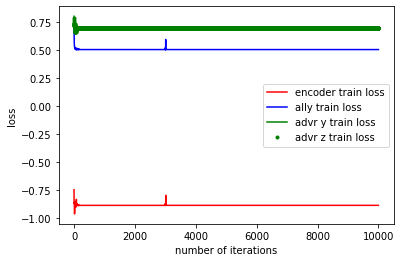

In [71]:
alpha = 0.5
lr_encd = 0.1
lr_ally = 0.01
lr_advr = 0.01
n_iter_gan = 10001
d_reps = 1

# alpha = 0.5
# lr_encd = 0.01
# lr_ally = 0.001
# lr_advr = 0.0001
# n_iter_gan = 5001
# d_reps = 2


encoder = train_privacy_gan(alpha, lr_encd, lr_ally, lr_advr, n_iter_gan, d_reps, plot=True, debug=True)

# Training Independently

In [194]:
encoding_dimension = 3
encoder.eval()

Encoder(
  (fc1): Linear(in_features=3, out_features=24, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=24, out_features=12, bias=True)
  (sigmoid): Sigmoid()
  (tanh): Tanh()
  (batchnorm): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [195]:
optimizer = torch.optim.Adam

In [196]:
ally = Ally(
    input_size=encoding_dimension*4, 
    hidden_size=encoding_dimension*8, 
    output_size=y_ally_torch.shape[1])
criterion = torch.nn.BCEWithLogitsLoss()
ally_optimizer = optimizer(ally.parameters(), lr=0.01)

print("epoch \t ally_train")

ally.train()

n_iter = 10001
    
for epoch in range(n_iter):
    X_ganencoded = encoder(X_torch)
    y_ally_torch_hat = ally(X_ganencoded)
    ally_optimizer.zero_grad()
    ally_loss = criterion(y_ally_torch_hat, y_ally_torch)
    ally_loss.backward()
    ally_optimizer.step()
    
    if epoch%1000!=0:
        continue

    print('{} \t {:.8f}'.format(
        epoch, 
        ally_loss.item(),
    ))
    

epoch 	 ally_train
0 	 0.72547853
1000 	 0.50320965
2000 	 0.50320590
3000 	 0.50320518
4000 	 0.50320446
5000 	 0.50320441
6000 	 0.50320429
7000 	 0.50320429
8000 	 0.50320429
9000 	 0.50320423
10000 	 0.50320423


In [197]:
adversary_y = Adversary(
    input_size=encoding_dimension*4, 
    hidden_size=encoding_dimension*8, 
    output_size=y_advr_y_torch.shape[1])

advr_y_optimizer = optimizer(adversary_y.parameters(), lr=0.01)

print("epoch \t advr_train")

adversary_y.train()
    
for epoch in range(n_iter):
    X_ganencoded = encoder(X_torch)
    y_advr_y_torch_hat = adversary_y(X_ganencoded)
    advr_y_optimizer.zero_grad()
    advr_y_loss = criterion(y_advr_y_torch_hat, y_advr_y_torch)
    advr_y_loss.backward()
    advr_y_optimizer.step()
    
    if epoch%1000!=0:
        continue
    
    print('{} \t {:.8f}'.format(
        epoch, 
        advr_y_loss.item(),
    ))
    

epoch 	 advr_train
0 	 0.72948432
1000 	 0.69314778
2000 	 0.69314748
3000 	 0.69314688
4000 	 0.69314730
5000 	 0.69314718
6000 	 0.69314688
7000 	 0.69314736
8000 	 0.69314688
9000 	 0.69314659
10000 	 0.68908143


In [198]:
adversary_z = Adversary(
    input_size=encoding_dimension*4, 
    hidden_size=encoding_dimension*8, 
    output_size=y_advr_z_torch.shape[1])

advr_z_optimizer = optimizer(adversary_z.parameters(), lr=0.01)

print("epoch \t advr_train")

adversary_z.train()
    
for epoch in range(n_iter):
    X_ganencoded = encoder(X_torch)
    y_advr_z_torch_hat = adversary_z(X_ganencoded)
    advr_z_optimizer.zero_grad()
    advr_z_loss = criterion(y_advr_z_torch_hat, y_advr_z_torch)
    advr_z_loss.backward()
    advr_z_optimizer.step()
    
    if epoch%1000!=0:
        continue
    
    print('{} \t {:.8f}'.format(
        epoch, 
        advr_z_loss.item(),
    ))
    

epoch 	 advr_train
0 	 0.72579992
1000 	 0.69314480
2000 	 0.69003040
3000 	 0.68490660
4000 	 0.69314712
5000 	 0.69314712
6000 	 0.69314712
7000 	 0.69314706
8000 	 0.69314706
9000 	 0.69314706
10000 	 0.69314706


# DP

In [ ]:
def laplaceMechanism(x, epsilon):
    return x + np.random.laplace(0, 1.0/epsilon, x.shape)

In [ ]:
epsilons = [1, 10, 100, 1000]
for epsilon in epsilons:
    X_dp = laplaceMechanism(X_normalized, epsilon)

    class_plot(X_dp, title="DP at epsilon={}".format(epsilon))

In [ ]:
np.random.laplace(0, 1.0/100000, X_dp.shape)